# Time Constructions

Towards a usage-based, constructional taxonomy of time indicators in Biblical Hebrew.

In [1]:
import collections, csv, random
from textwrap import indent
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from tf.fabric import Fabric
from tf.app import use

custom_data = ['/Users/cody/text-fabric-data/etcbc/bhsa/tf/c',
               '/Users/cody/github/etcbc/heads/tf/c',
               '../data/',
               '../data/funct_associations/'
              ]

TF = Fabric(locations=custom_data)
api = TF.load('''

vs vt pdp gloss lex language 
rela typ number function prs
g_cons_utf8 nu mother st uvf
head nhead obj_prep sem_set
ls topAssoc TimeAssoc LocaAssoc
label role
''')

A = use('bhsa', api=api, hoist=globals(), silent=True)

A.displaySetup(condenseType='clause', condensed=True, withNodes=True)

This is Text-Fabric 7.4.11
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

142 features found and 4 ignored
  0.00s loading features ...
   |     0.15s B g_cons_utf8          from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.14s B lex                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.11s B vs                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.10s B vt                   from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.10s B pdp                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.12s B gloss                from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.10s B language             from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.17s B rela                 from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.17s B typ                  from /Users/cody/text-fabric-data/etcbc/bhsa/tf/c
   |     0.18s B number               from /Users

In [2]:
def findLex(lex_str):
    '''
    Finds a lex node.
    '''
    return [(l, F.gloss.v(l), F.lex.v(l)) 
                for l in F.otype.s('lex')
                if lex_str == F.lex.v(l)]

def flattenNodes(nodeList):
    '''
    Takes any list of mixed node types
    and flattens them to a list of slots.
    '''
    slots = []
    for n in nodeList:
        if F.otype.v(n) == 'word':
            slots.append(n)
        else:
            slots.extend(L.d(n, 'word'))
    return sorted(set(slots))

### Tokenization Strategy

One of the goals in this analysis is to see broad tendencies which various constructions of time have in common. Tokenization is a data-oriented way to create sets of similar forms. For instance, the quantifier NP construction is ubiquitous within time constructions. Rather than tokenizing the individual parts of that construction, such as the number lexeme, connecting waws, or the quantified noun, it is better that the whole quantified expression be tokenized as a single unit.

This actually presents a difficult programming challenge: how to know when to tokenize a word with lexical content and when to do so with a particular tag? If we tag an entire quantifier construction with a tag, the algorithm should recognize that it should not tokenize the component words. Furthermore, the system needs to be extendable, so that additional filters can be added as needed. 

The solution comes by mapping the first word of a construction to a set of skip words. For every unit above the word level, we add the first word as a key to a dictionary. The value is another dictionary which contains both a token and skip-words. The skip-words contain the rest of the construction, which are added to a skip-set. For every time phrase, all words are iterated over. Those words that are in the token dictionary will trigger the token and the addition of skip words. The algorithm will then skip over words that follow that word as needed.

In [171]:
customtokens = {}

# first map tokens for all objects > word
# map first word to token, map all subsequent words in object to empty string

# map tokens for highest level quantifier constructions
for qc in F.label.s('quant_NP') + F.label.s('quant_NP_chain'):
    # skip embedded constructions
    if [qc for qc in L.u(qc, 'construction') if F.label.v(qc) == 'quant_NP_chain']:
        continue
    qc_words = L.d(qc, 'word')
    customtokens[qc_words[0]] = 'quantNP'
    customtokens.update(dict((w, '') for w in qc_words[1:])) # add blank tokens for remaining terms
    
# map preposition chunks to prep token
# a "chunk" is when prepositions are stacked
for pc in F.label.s('prep'):
    pc_words = L.d(pc, 'word')
    customtokens[pc_words[0]]  = 'prep'
    customtokens.update(dict((w, '') for w in pc_words[1:]))
    
# now add word tokens, checking to make sure they're not already accounted for
    
# all words in time phrases
tp_words = [w for tp in F.otype.s('phrase2') 
                if F.function.v(tp) == 'Time'
                for w in L.d(tp, 'word')]
    
for word in tp_words:

    # skip words already tokenized
    if word in customtokens:
        continue
        
    # token articles
    elif F.lex.v(word) == 'H':
        customtokens[word] = 'H'

    # token ordinals
    elif F.ls.v(word) == 'ordn':
        customtokens[word] = 'ordn'

    # token qualitative quantifiers
    elif (F.sem_set.v(word) == 'quant') and (not F.ls.v(word) == 'card'):
        customtokens[word] = 'qualQuant'
    
    # token head words 
    elif E.nhead.f(word):
        customtokens[word] = 'time'

    # token demonstratives
    elif F.pdp.v(word) == 'prde':
        customtokens[word] = 'dem'
    
    # token likely adjuncts
    elif F.pdp.v(word) in {'subs', 'adjv'}:
        customtokens[word] = 'adju'
        
len(customtokens)

86657

Now we are ready to tokenize phrases...

In [172]:
def tokenizePhrase(phrasenode):
    '''
    Maps words either to standard token
    or to custom token based on token dictionary.
    Returns a full token string for the phrase.
    '''
    
    minitokens = []
    
    for word in L.d(phrasenode, 'word'):
        if word in customtokens:
            minitokens.append(customtokens[word])
        else:
            minitokens.append(F.pdp.v(word))
        
    minitokens = [tok for tok in minitokens if tok] # filter out empty strings
        
    return '.'.join(minitokens)

## Prepare to Write Construction Objects

Previously calculated database features are loaded so they are included in eventual export.

In [122]:
edgeFeatures = collections.defaultdict(lambda:collections.defaultdict())
nodeFeatures = collections.defaultdict(lambda:collections.defaultdict())
node = max(N())

# add previously calculated features
nodeFeatures['otype'] = dict((n, F.otype.v(n)) for n in N())
edgeFeatures['oslots'] = dict((n, L.d(n, 'word')) for n in N() if F.otype.v(n) != 'word')
nodeFeatures['label'] = dict((n, F.label.v(n)) for n in N() if F.label.v(n))
nodeFeatures['role'] = {} # role
for n in N():
    for mother, role in E.role.f(n):
        nodeFeatures['role'][n] = {mother:role}

## Measuring Time Phrase Dispersion

This analysis of time constructions is based on frequency. In a usage-based approach to language, highly frequent terms are the prototypes which other structures in the language are based on. In the analysis of time constructions, the top occurring surface forms, or tokens, are proposed to represent the primary means of representing time. However, raw frequencies can be misleading. For this reason, we apply a frequency adjustment as suggested by Stefan Gries.

In [173]:
time_tokens = collections.defaultdict(lambda:collections.Counter())
time_phrases = set()
explore2results = collections.defaultdict(list)

times = A.search('''

phrase2 function=Time
/without/
    word lex=>K|>Z|<TH|KN
/-/
    word language=Hebrew

''', shallow=True)

for tp in times:
    token = tokenizePhrase(tp)
    book, chapter, verse = T.sectionFromNode(tp)
    time_tokens[book][token] += 1
    explore2results[token].append((tp,))
    time_phrases.add(tp)
    
time_tokens = pd.DataFrame(time_tokens).fillna(0)
timetok_summary = pd.DataFrame(time_tokens.sum(1).sort_values(ascending=False), columns=['sum'])

  1.66s 3376 results


In [174]:
timetok_summary.shape

(312, 1)

In [175]:
timetok_summary.head(30)

,sum
prep.time,549.0
prep.H.time.H.dem,428.0
quantNP,325.0
prep.H.time,307.0
H.time,215.0
time,209.0
prep.time.adju,155.0
prep.H.time.H.ordn,147.0
qualQuant.H.time,100.0
prep.quantNP,63.0


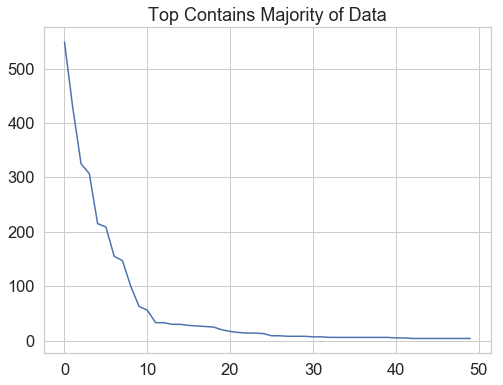

In [167]:
plt.figure(figsize=(8, 6))
plt.plot(timetok_summary['sum'].values[:50])
plt.title('Top Contains Majority of Data')
plt.show()

Total number of time phrases accounted for in top 11 tokens:

In [161]:
timetok_summary['sum'][:11].sum()

2554.0

In fact, this is 75% of the data:

In [168]:
timetok_summary['sum'][:11].sum() / len(times)

0.7565165876777251

Here are those tokens:

In [169]:
timetok_summary[:12]

,sum
prep.time,549.0
prep.H.time.H.dem,428.0
quantNP,325.0
prep.H.time,307.0
H.time,215.0
time,209.0
prep.time.adju,155.0
prep.H.time.H.ordn,147.0
qualQuant.H.time,100.0
prep.quantNP,63.0


In [177]:
showme = explore2results['prep.time.conj.time']

#A.show([L.d(res[0]) for res in showme], end=20, condenseType='sentence')

# NB: all activity below is now outdated. Now that I have an efficient way of tokenizing the phrases, it is a much better starting point for analyiss. Going forward, I think I will remove most of the analysis below since it only repeats the analysis above, but less elegantly and accurately so. -11 April 2019, Cody

## Querying Constructions

Attempting to describe the most productive constructions.

In [9]:
token2results = collections.defaultdict(list)
found_phrases = set()

def show_progress(setA, setB):
    lenA, lenB = len(setA), len(setB)
    print(f'{lenA} / {lenB}\t{round(lenA/lenB, 2)}')

### 1. prep + H + timeNoun + H + demonstrative/ordinal/other

The ב.ה.יום.ה.הוא construction is the most common with a relatively high DP score of (0.56), and there are numerous similar variants of this construction. Below I aim to represent this construction abstractly, with each of the pieces constructed with parts of speech fillers. I want to see how much of the data this construction accounts for, and I want to compare its distribution and use accross other categories and functions. 

In [10]:
hh_cx = A.search('''

phrase2 function=Time
    chunk label=prep
    <: word lex=H language=Hebrew
    <: word pdp=subs
    <: word lex=H
    <: word
    /with/
    pdp=prde
    /or/
    ls=ordn
    /-/

''')

hh_name = 'prep_H_time_H_{}'
token2results[hh_name] = hh_cx

# log time construction object
for result in hh_cx:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    named_slot = 'demon' if F.pdp.v(result[5]) == 'prde' else 'ordinal'
    nodeFeatures['label'][node] = hh_name.format(named_slot)
    edgeFeatures['oslot'][node] = tuple(L.d(result[1], 'word')) + result[2:]
    edgeFeatures['role'][result[2]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'orient':node}
    edgeFeatures['role'][result[-1]] = {named_slot:node}

# report progress
print()
show_progress(found_phrases, time_phrases)

  0.51s 715 results

696 / 3376	0.21


In [11]:
#A.show(hh_cx)

### 1.1 ø + H + timeNoun + H + demonstrative/ordinal

In [12]:
hh_cx = A.search('''

phrase2 function=Time
/without/
    chunk label=prep
/-/
    word lex=H language=Hebrew
    <: word pdp=subs
    <: word lex=H
    <: word
    /with/
    pdp=prde
    /or/
    ls=ordn
    /-/

''')

hh_name = 'H_time_H_{}'
token2results[hh_name] = hh_cx

# log time construction object
for result in hh_cx:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    named_slot = 'demon' if F.pdp.v(result[-1]) == 'prde' else 'ordinal'
    nodeFeatures['label'][node] = hh_name.format(named_slot)
    edgeFeatures['oslot'][node] = tuple(L.d(result[1], 'word')) + result[2:]
    edgeFeatures['role'][result[2]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'orient':node}
    edgeFeatures['role'][result[-1]] = {named_slot:node}

# report progress
print()
show_progress(found_phrases, time_phrases)

  0.52s 35 results

731 / 3376	0.22


### 2. H + timeNoun

In [13]:
the_cx = A.search('''

p:phrase2 function=Time
    =: word lex=H language=Hebrew
    <: w1:word pdp=subs
p := w1

''')

the_cx_name = 'H_time'
token2results[the_cx_name] = the_cx

for result in the_cx:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = the_cx_name
    edgeFeatures['oslot'][node] = L.d(result[0], 'word')
    edgeFeatures['role'][result[2]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'H':node}
    
print()
show_progress(found_phrases, time_phrases)

  1.74s 216 results

947 / 3376	0.28


In [14]:
#A.show(the_cx, condenseType='sentence', extraFeatures='st')

### 3. Quantified Constructions (מ׳׳)

Time constructions with quantifiers seem to inherit the quantified NP construction, and there are thus relatively complex chains that are formed. These constructions are pre-processed into quantifier constructions in [quantifier_constructions.ipynb](preprocessing/quantifier_constructions.ipynb). The result is a new object, constructions, and constructions with a label of 'quantified_NP' are base units of constructions.

#### Count Quantifier Construction Types

In [15]:
def tokenQuants(phrasenode):
    '''
    Generic tokenizer
    for non-tagged constructions.
    '''
    
    words = list(L.d(phrasenode, 'word'))
    token = []
    i = 0 
    while i < len(words):
        word = words[i]
        i += 1
        
        construct = next((c for c in L.u(word, 'chunk') if F.label.v(c) != 'prep'), 0)

        # replace quantified cx
        if construct:
            
            if F.label.v(construct) in {'quant_NP', 'quant_NP_chain'}:
            
                construct = sorted((len(L.d(cx, 'word')), cx)
                                    for cx in L.u(word, 'chunk')
                                    if 'quant_NP' in F.label.v(cx))[-1][1]
                token.append('מד׳׳')

            elif F.label.v(construct) == 'quant':
                token.append('מ׳׳')
                
            # skip subsequent words in the construction
            i += len(L.d(construct, 'word'))-1

            
        elif F.lex.v(word) == 'H':
            token.append('ה')
            
        else:
            
            if token and token[0] == 'מד׳׳': # ignore additional modifiers
                token = ['מד׳׳']
                i = len(words)
            
            else:
                token.append(F.g_cons_utf8.v(word))
            
    return '.'.join(token)

In [16]:
qmeta = [] # put all construction data here
count_quants = collections.Counter()

prep_time_l_time = A.search('''

sentence
    chunk label=prep
    <: word st=c ls#card
    <1: c1:chunk label=quant_NP|quant_NP_chain|quant
    /with/
    :> word pdp=art
    /or/
    :> word st=c ls#card
    /-/
    
    /without/
    chunk
        ..
    /-/
        word
    w1:word lex=L language=Hebrew
    <: word sem_set#prep

    c1 <: w1
''') 

qmeta.append({'results': prep_time_l_time,
              'label':'prep_q[time]_L',
              'phrase2_ref': 1,
              'oslot_ends': (1, 6),
              'semroles':{1:'orient',
                          2:'time',
                          3:'quantNP',
                          5:'L',
                          6:'reference'
                          }
              })

    
prep_l_time = A.search('''

sentence
    chunk label=prep
    <: c1:chunk label=quant_NP|quant_NP_chain|quant

    /without/
    chunk
        ..
    /-/
        word
    w1:word lex=L language=Hebrew
    <: word sem_set#prep

    c1 <: w1
''') 


qmeta.append({'results': prep_l_time,
              'label':'prep_q[time]_L',
              'phrase2_ref': 1,
              'oslot_ends': (1, 5),
              'semroles':{1:'orient',
                          2:'quantNP',
                          4:'L',
                          5:'reference'
                          }
              })


# This pattern is very long because 
# there are restrictions needed to ensure that
# the quantified NP time phrase is truly
# standing on its own without contributing
# to a larger construction
prep_qTime = A.search('''

sentence
    phrase2 function=Time
        chunk label=prep
        /without/
        phrase2
            chunk label=quant_NP|quant_NP_chain|quant
            <: ..
        /-/
        /without/
        phrase2
            phrase_atom typ=PP
            <: ..
        /-/
            =: word lex#>T
        
        <: chunk label=quant_NP|quant_NP_chain
        /without/
        chunk
            ..
        /-/
        /without/
        ..
        <: word pdp=prep language=Hebrew
        /-/
        /without/
        phrase2
            ..
            < word pdp=prep
        /-/
        /without/
        sentence
            ..
            < phrase function=Time typ=PP
        /-/

''') 
token = 'prep_qNP'

qmeta.append({'results': prep_qTime,
              'label':'prep_qNP',
              'phrase2_ref': 2,
              'oslot_ends': (2, 4),
              'semroles':{2:'orient',
                          4:'quantNP',
                          }
              })    
    
# PUT NEW LOOP HERE!
    
these_phrases = set()

for query in qmeta:
    token2results[query['label']] = query['results']
    
    for res in query['results']:
        count_quants[query['label']] += 1

        # update phrase2 tracking
        phrase2 = L.u(res[query['phrase2_ref']], 'phrase2')[0]
        found_phrases.add(phrase2)
        these_phrases.add(phrase2)
        
        # map to CX object
        node += 1
        nodeFeatures['otype'][node] = 'construction'
        nodeFeatures['label'][node] = query['label']
        start, end = query['oslot_ends']
        edgeFeatures['oslot'][node] = flattenNodes(res[start:end+1])
        for i, semrole in query['semroles'].items():
            edgeFeatures['role'][res[i]] = {semrole:node}
            
print('\n', len(these_phrases), 'phrases accounted for in these loops')

  2.44s 165 results
  1.54s 165 results
  0.81s 54 results

 202 phrases accounted for in these loops


In [17]:
show_progress(found_phrases, time_phrases)

1109 / 3376	0.33


#### Remaining cases

In [18]:
remaining2res = collections.defaultdict(list)

quant_cx = A.search('''

phrase2
    phrase function=Time
        <nhead- word pdp=subs
        word ls=card language=Hebrew
 
''')
    
these_phrases = set()
unknown_phrases = set()
    
for result in quant_cx:
    
    if result[0] in found_phrases:
        continue
    
    ph_token = tokenQuants(result[0])
    
    # case-by-case basis constructions handled here
    # these are constructions where it is easier to 
    # take the subset of phrases  NOT yet accounted for
    # since the other cases are by now filtered out
    
    # handle durative cases
    if ph_token == 'מד׳׳':
                
        ph_token = 'ø_quantNP'
        found_phrases.add(result[0])
        these_phrases.add(result[0])
        
        node += 1
        nodeFeatures['otype'][node] = 'construction'
        nodeFeatures['label'][node] = ph_token
        edgeFeatures['oslot'][node] = L.d(result[0], 'word')
        edgeFeatures['role'][result[2]] = {'timenoun':node}
    
    else:
        unknown_phrases.add(result[0])
    
    # all other cases just count them
    count_quants[ph_token] += 1
    remaining2res[ph_token].append(result)
    
print()
print(f'phrases added here:\t{len(these_phrases)}')
print(f'phrases NOT added:\t{len(unknown_phrases)}')

print('\nTOTAL progress')
show_progress(found_phrases, time_phrases)

  1.83s 1005 results

phrases added here:	339
phrases NOT added:	49

TOTAL progress
1448 / 3376	0.43


### Inspect What Is There

In [19]:
count_quants = pd.DataFrame(count_quants.most_common())

In [20]:
showresult = 0
showme = remaining2res['ב.מד׳׳']

#A.show(showme, extraFeatures='st', condenseType='sentence')

In [21]:
count_quants.shape

(41, 2)

In [22]:
count_quants

,0,1
0,ø_quantNP,339
1,prep_q[time]_L,330
2,prep_qNP,54
3,מד׳׳.מד׳׳,8
4,ב.מ׳׳.בו,8
5,ב.מ׳׳.בו.ו.ב.מ׳׳.בו,8
6,אחר.ה.מבול.מד׳׳,6
7,עד.ערב.מד׳׳,6
8,ב.יום.מד׳׳,4
9,את.מ׳׳.ה.יום.ו.את.מ׳׳.ה.לילה,4


### 3.1 Qualitative Quantifiers (ø)

In [23]:
null_qq = A.search('''

phrase2 function=Time
/without/
    chunk label=prep
/-/
    word sem_set=quant ls#card language=Hebrew
    <1: word pdp=subs ls#card
    /with/
    :> word pdp=art
    /or/
    :> word sem_set=quant ls#card
    /-/
''')


null_qq_name = 'ø_qualityQuant_NP'
token2results[null_qq_name] = null_qq

for result in null_qq:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = null_qq_name
    edgeFeatures['oslot'][node] = result
    edgeFeatures['role'][result[2]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'qualQuant':node}

print()
show_progress(found_phrases, time_phrases)

  1.62s 191 results

1625 / 3376	0.48


In [24]:
random.shuffle(null_qq)

### 3.2 Dual-Endings

Nouns that are otherwise unmarked for number can be marked with a dual ending.

In [25]:
timeDual = A.search('''

phrase2 function=Time
    =: chunk label=prep
    <1: word nu=du ls#card
    /with/
    :> word pdp=art
    /or/
    :> chunk label=prep
    /-/
    
''')

tDual_name = 'prep_timeDual'
token2results[tDual_name] = timeDual

for result in timeDual:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = tDual_name
    edgeFeatures['oslot'][node] = flattenNodes(result[1:])
    edgeFeatures['role'][result[2]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'orient':node}
    
print()
show_progress(found_phrases, time_phrases)

  0.95s 25 results

1650 / 3376	0.49


### 4. PP + NP

In [26]:
pp_np = []

pp_np_query = '''

p:phrase2 function=Time
/without/
    word
    /with/
    <mother- clause
    /or/
    sem_set=quant
    /or/
    nu=du
    /or/
    pdp=prde|conj
    /-/
/-/
    =: chunk label=prep
    /without/
    phrase2
        ..
        << word pdp=prep
    /-/
    
    {option}
    
    <: n:word pdp=subs ls#card sem_set#prep language=Hebrew
'''

for option in {'', '<: word pdp=art'}:
    pp_np.extend(A.search(pp_np_query.format(option=option)))

ppnp_name = 'prep_time'
token2results[ppnp_name] = pp_np

for result in pp_np:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = ppnp_name
    edgeFeatures['oslot'][node] = L.d(result[0], 'word')
    edgeFeatures['role'][result[-1]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'orient':node}
    
print()
show_progress(found_phrases, time_phrases)

  2.79s 665 results
  2.88s 460 results

2628 / 3376	0.78


In [27]:
#random.shuffle(pp_np)

In [28]:
#A.show(pp_np, extraFeatures='st', condensed=False, condenseType='clause')

### 3.1. prep + noun + inf_verb_clause

In [29]:
pp_np_cl = A.search('''

phrase2 function=Time
    =: chunk label=prep
    w1:word pdp=subs language=Hebrew
    
w1 
<mother- clause
    
''')


pptc_name = 'prep_time_clause'
token2results[pptc_name] = pp_np_cl

for result in pp_np_cl:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = pptc_name
    edgeFeatures['oslot'][node] = flattenNodes(result)
    edgeFeatures['role'][result[2]] = {'timenoun':node}
    edgeFeatures['role'][result[1]] = {'orient':node}
    edgeFeatures['role'][result[-1]] = {'event':node}

print()
show_progress(found_phrases, time_phrases)

  1.73s 114 results

2736 / 3376	0.81


### 3.2 prep + inrg

The preposition + interrogative construction is related to the prep+NP construction. The interrogative particle is extended into the position of a noun. In many cases, these nouns are habitually associated with temporal question phrases, e.g. מתי

In [30]:
prep_inrg = A.search('''

p:phrase2 function=Time
    =: chunk label=prep
    <: w1:word pdp=inrg language=Hebrew

''')

pp_inrg_name = 'prep_timeQuestion'
token2results[pp_inrg_name] = prep_inrg

for result in prep_inrg:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = pp_inrg_name
    edgeFeatures['oslot'][node] = L.d(result[0], 'word')
    edgeFeatures['role'][result[2]] = {'timeQuestion':node}
    edgeFeatures['role'][result[1]] = {'orient':node}

print()
show_progress(found_phrases, time_phrases)

  1.19s 39 results

2775 / 3376	0.82


In [31]:
#random.shuffle(prep_inrg)

In [32]:
#A.show(prep_inrg)

### 3.3 prep + pronominal suffix

This construction is also related to the prep+NP, especially in the sense the the NP often takes a suffix when refering to event-type nouns. The cases below consist of time constructions where a preposition is the only item, and a pronominal suffix is attached to it. These cases seem to involve some existential sense related to a person: "after me", "after them" i.e. "after [I exist]". In fact, the preposition seems to play a kind of double duty in theses cases: both as a sort of noun and as a preposition.

In [33]:
prep_sffx = A.search('''

p:phrase2 function=Time
    w1:word pdp=prep prs#absent

p =: w1
p := w1
''')

prep_sffx_name = 'prep_suffix'
token2results[prep_sffx_name] = prep_sffx

for result in prep_sffx:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = prep_sffx_name
    edgeFeatures['oslot'][node] = L.d(result[0], 'word')
    edgeFeatures['role'][result[1]] = {'orientExist':node}

print()
show_progress(found_phrases, time_phrases)

  0.77s 34 results

2809 / 3376	0.83


In [34]:
#random.shuffle(prep_sffx)

In [35]:
#A.show(prep_sffx, condensed=False)

### 4. "Adverb" Only

In [36]:
advb = A.search('''

p:phrase2 function=Time
    w1:word pdp=advb lex#>K|>Z|<TH|KN language=Hebrew

w1 =: p
w1 := p
''')


advb_name = 'timeAdvb'
token2results[advb_name] = advb

for result in advb:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = advb_name
    edgeFeatures['oslot'][node] = result
    edgeFeatures['role'][result[0]] = {'timenoun':node}

print()
show_progress(found_phrases, time_phrases)

  1.41s 179 results

2988 / 3376	0.89


In [37]:
random.shuffle(advb)

In [38]:
#A.show([res for res in advb if F.lex.v(res[1]) == '>XR/'], condensed=False, condenseType='sentence')

### 5. timeNoun Only

If a timenoun solely occupies the time construction it is nearly always morphologically marked in some way. Two cases are seen: time nouns with dual endings (indicating a specified segment of time), and time nouns with plural endings (indicating an unmarked duration). While different in function, these time nouns are similar in form, and they especially resemble the adverbials recognized above.  

### 6. PP/NP Repetition

The repetition of the same phrase/noun twice is used to indicate repetitive, cyclic time. This takes advantage of the repeating noun construction used to represent plurality, but the function is extended in the time function. This highlights how plurality can be an indicator of time duration.

This analysis requires some hand-coding.

In [39]:
repeats = []

pp_pp = '''

phrase2 function=Time
    chunk label=prep
    {option}
    <: word pdp=subs
    <: chunk label=prep
    {option}
    <: word pdp=subs
'''

pp_pp = [res for opt in ('', '<: word pdp=art')
            for res in A.search(pp_pp.format(option=opt), silent=True)]

for res in pp_pp:
    prep1, prep2 = (c for c in res if F.otype.v(c) == 'chunk')
    word1, word2 = (w for w in res if F.pdp.v(w) != 'art' and w not in {prep1, prep2, res[0]})
    prepT1, prepT2 = [T.text(prep, fmt='text-orig-plain', descend=True) for prep in (prep1, prep2)]
    wordT1, wordT2 = [F.g_cons_utf8.v(w) for w in (word1, word2)]
    
    if all([prepT1 == prepT2,
            wordT1 == wordT2]):
        repeats.append(res)
        
print(f'{len(res)} pp results...')


np_np = A.search(f'''

phrase2 function=Time
/without/
    chunk label=prep
/-/
    word
    <: word    
    
''', silent=True)

npnpct = 0
for res in np_np:
    
    word1, word2 = F.g_cons_utf8.v(res[1]), F.g_cons_utf8.v(res[2])
    
    if word1 == word2:
        repeats.append(res)
        npnpct += 1
        
print(f'{npnpct} nn results...')

7 pp results...
9 nn results...


In [40]:
trepeat = 'timeRepeat'
token2results[trepeat] = repeats

for result in repeats:
    found_phrases.add(result[0])
    node += 1
    nodeFeatures['otype'][node] = 'construction'
    nodeFeatures['label'][node] = trepeat
    edgeFeatures['oslot'][node] = result
#     edgeFeatures['semrole'][result[0]] = {'timenoun':node}

print()
show_progress(found_phrases, time_phrases)


3012 / 3376	0.89


In [41]:
#random.shuffle(repeats)

In [42]:
#A.show(repeats, condensed=False, condenseType='phrase')

## STATUS CHECK

In [57]:
stats = dict((token, len(res)) for token, res in token2results.items())
stats = pd.DataFrame.from_dict(stats, orient='index', columns=['count'])
stats.sort_values(by='count', ascending=False)

,count
prep_time,1125
prep_H_time_H_{},715
H_time,216
ø_qualityQuant_NP,191
timeAdvb,179
prep_q[time]_L,165
prep_time_clause,114
prep_qNP,54
prep_timeQuestion,39
H_time_H_{},35


In [58]:
stats['count'].sum()

2917

In [43]:
remaining_tp = time_phrases-found_phrases
remaining_patterns = collections.Counter()
remain2result = collections.defaultdict(list)

for tp in remaining_tp:
    token = tokenPhrase(tp, tokener=tokenWord)
    remaining_patterns[token] += 1
    remain2result[token].append(L.d(tp, 'word'))
    
remaining_patterns = pd.DataFrame.from_dict(dict(remaining_patterns.most_common()), orient='index')

In [44]:
conj_tags = [t for t in remaining_patterns.index if 'conj' in t]

remaining_patterns.head(10)

,0
subs,31
prep.subs.subs,24
prep.subs.conj.subs,20
subs.adjv,19
prep.subs.ha.subs.ha.prde,19
advb.conj.advb,19
prep.subs.prep.subs,15
subs.subs,14
prep.ha.subs.conj.prep.ha.subs,10
prep.advb,8


In [12]:
#A.show(remain2result['subs'], condenseType='sentence', extraFeatures='sem_set ls nu st')

In [ ]:
(res for res in )

### Chained PP?

In [45]:
missingp2 = set(ph for ph in F.otype.s('phrase2') if ph not in found_phrases)

t = A.search('''

missingphrase2 function=Time
    construction label=prep
    << construction label=prep

''', sets={'missingphrase2':missingp2})

  0.60s 178 results


In [46]:
#A.show([L.d(ph[0], 'word') for ph in t])

primitives

* NP chunks — chunk from head to head **[head mod mod mod CONJ head mod]**, split on conj (conjunction) or **[head mod mod head mod]** split on head.
    * have to account for "prefixed" entities: namely definite article

# Scratch Code

## Other cases of H+noun+H+modifier

In [47]:
# A.show(A.search('''

# phrase2 function=Time
#     word lex=H
#     <: word pdp=subs
#     <: word lex=H
#     <: word ls#ordn pdp#prde

# '''))

### Calculate Degree of Dispersion *DP*

In [48]:
# # count all phrase tokens in all books
# phrase_tokens = collections.defaultdict(lambda:collections.Counter())

# for phrase in F.otype.s('phrase'):
#     book, chapter, verse = T.sectionFromNode(phrase)
#     phrase_tokens[book][tokenPhrase(phrase)] += 1
    
# phrase_tokens = pd.DataFrame(phrase_tokens).fillna(0)

# phrase_tokens.shape

# expected_prop = phrase_tokens.sum() / phrase_tokens.sum().sum()
# observed_prop = time_tokens.div(time_tokens.sum(1), axis=0)
# prop_diffs = abs(expected_prop-observed_prop)
# dp = 1-pd.DataFrame(prop_diffs.sum(1) / 2, columns=['DP'])

# time_dp_total = pd.concat((dp, time_tokens.sum(1)), axis=1)
# time_dp_total.columns = ('DP', 'Total')
# time_dp_total = time_dp_total[['Total', 'DP']]

# time_dp_total.sort_values(by='Total', ascending=False).head(20)

# dp.sort_values(ascending=False, by='DP').head(20)

In [49]:
# plt.figure(figsize=(8,6))
# plt.plot(sorted(dp.values, reverse=True), color='darkblue')
# plt.xlabel('Rank', size=18)
# plt.ylabel('DP', size=18)
# plt.title('DP Score by Token Rank')

In [50]:
# plt.figure(figsize=(8,6))
# plt.plot(sorted(time_tokens.sum(1).values, reverse=True), color='darkblue')
# plt.xlabel('Rank', size=18)
# plt.ylabel('Frequency', size=18)
# plt.title('Token Frequency by Rank')